In [ ]:
import trainExplainer
import importlib
import datasetLoader
import evaluation
import torch
import explainer
import networks

importlib.reload(trainExplainer)
importlib.reload(datasetLoader)

<module 'datasetLoader' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\datasetLoader.py'>

In [11]:
dataset="Tree-Cycles"

In [12]:
# TODO: Probably best to load data here once and pass to each task?

mlp, downstreamTask = trainExplainer.trainExplainer(dataset=dataset, save_model=False)

Epoch 1, Loss: 0.1385609656572342
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC of ROC: 0.440559446811676
BinaryAUROC: 0.4405594405594406
roc_auc_score: 0.4405594405594406
AUC not computable
AUC not computable
AUC of ROC: 0.5666666626930237
BinaryAUROC: 0.5666666666666667
roc_auc_score: 0.5666666666666667
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not computable
AUC not compu

train/Loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/mean_AUC,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/Loss,0.06496
val/mean_AUC,0.50361


In [ ]:
torch.save(mlp.state_dict(), f"models/explainerBA-Shapes")

In [ ]:
mlp, downstramTask = trainExplainer.loadExplainer(dataset=dataset)

AUC of ROC: 0.7083333134651184
BinaryAUROC: 0.7083333333333334
roc_auc_score: 0.7083333333333334
AUC of ROC: 0.7333333492279053
BinaryAUROC: 0.7333333333333333
roc_auc_score: 0.7333333333333333
AUC of ROC: 0.7424242496490479
BinaryAUROC: 0.7424242424242424
roc_auc_score: 0.7424242424242422
AUC of ROC: 0.4848484992980957
BinaryAUROC: 0.48484848484848486
roc_auc_score: 0.4848484848484848
AUC of ROC: 0.4848484992980957
BinaryAUROC: 0.48484848484848486
roc_auc_score: 0.4848484848484848
AUC of ROC: 0.7424242496490479
BinaryAUROC: 0.7424242424242424
roc_auc_score: 0.7424242424242422
AUC of ROC: 0.7333333492279053
BinaryAUROC: 0.7333333333333333
roc_auc_score: 0.7333333333333333
AUC of ROC: 0.4999999701976776
BinaryAUROC: 0.5
roc_auc_score: 0.5
AUC of ROC: 0.7333333492279053
BinaryAUROC: 0.7333333333333333
roc_auc_score: 0.7333333333333333
AUC of ROC: 0.7333333492279053
BinaryAUROC: 0.7333333333333333
roc_auc_score: 0.7333333333333333
AUC of ROC: 0.5209789872169495
BinaryAUROC: 0.520979020979

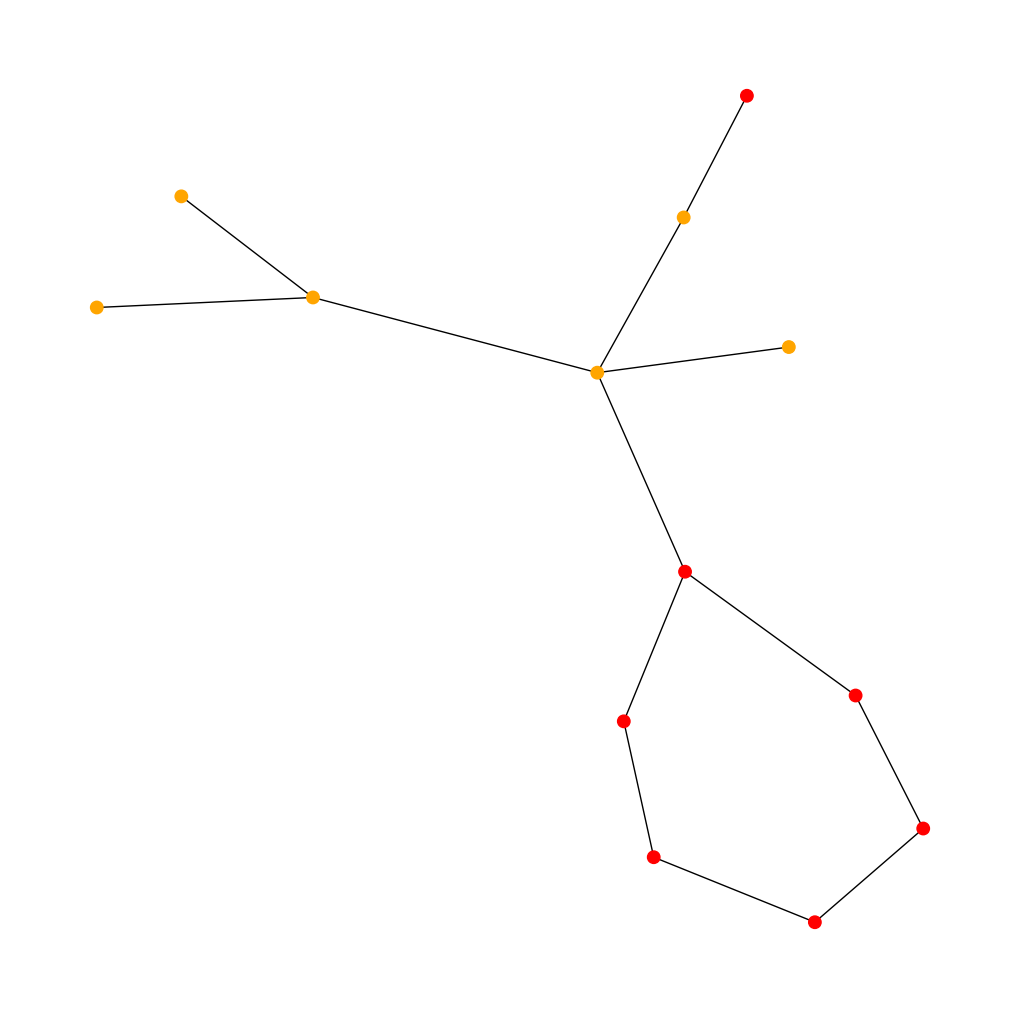

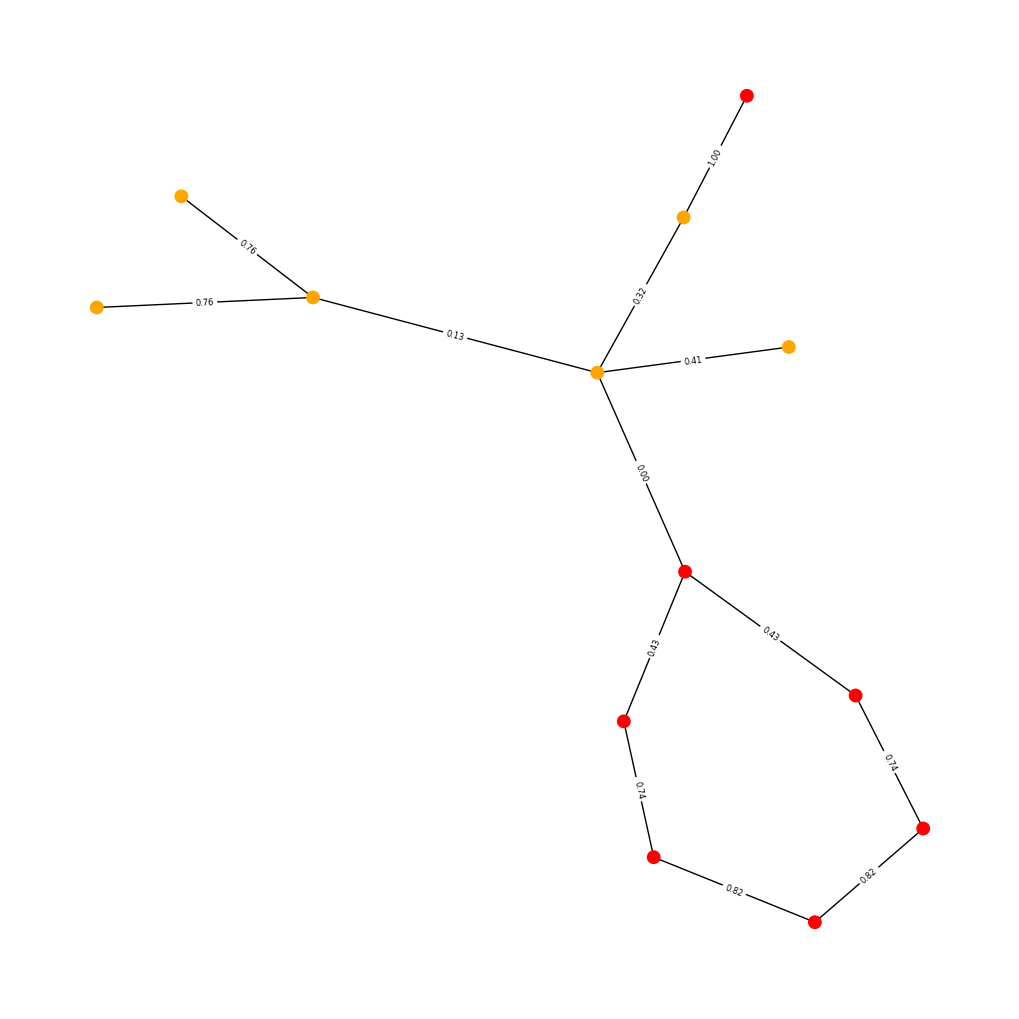

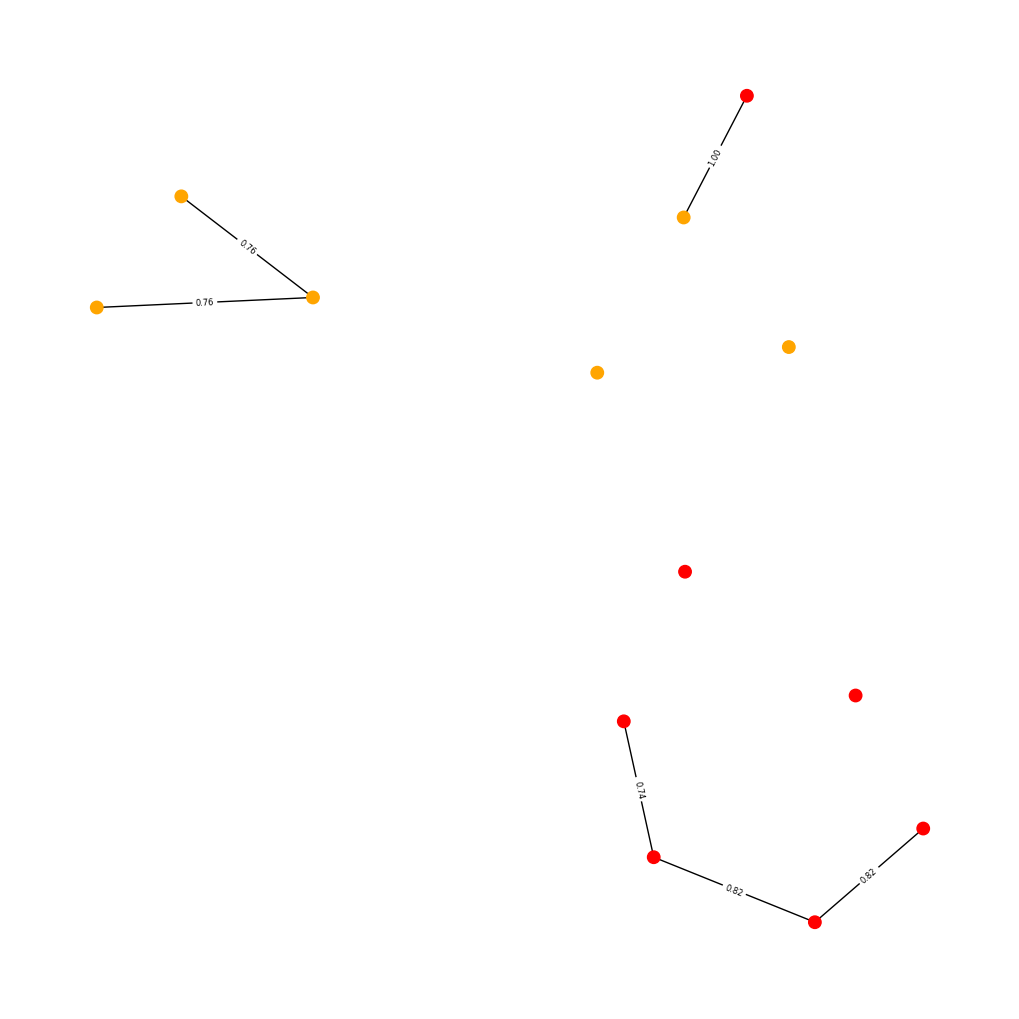

AttributeError: 'NoneType' object has no attribute 'to'

In [ ]:
importlib.reload(evaluation)

auc = evaluation.evaluate(datasetName=dataset, mlp=mlp, downstreamTask=downstreamTask)

print(f"Mean AUC for evaluation: {auc}")

In [8]:
import wandb
wandb.finish()

In [10]:
import utils
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [14]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [16]:
k = 5

data1 = data

printLoader = DataLoader([data1], 1, False)

temperature = 1

In [17]:
mlp.eval()
downstreamTask.eval()

w_ij = mlp.forward(downstreamTask, data1.x, data1.edge_index)

print(w_ij)

edge_ij = mlp.sampleGraph(w_ij)
print(edge_ij)

_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = data1.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

# edge_index_masked and weights_masked to display top 5 edges; data1.edge_index and w_ij to display original graph
Gs = Data(x=data1.x, edge_index=edge_index_masked, edge_attr=weights_masked)

#print(Gs.edge_attr)
#print(weights_masked)

print("-----------------Original Graph-----------------")

#pos = utils.plotGraph(data1, MUTAG=MUTAG)
pos = utils.plotGraphAll(data1, number_nodes=True, graph_task=True)

print("-----------------Sampled Graph-----------------")

#pos1 = utils.plotGraph(Gs, pos=pos, color_map=None, edge_weights=True, MUTAG=MUTAG)
pos1 = utils.plotGraphAll(Gs, pos=pos, number_nodes=True, graph_task=True, edge_weights=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4110x120 and 180x64)

In [18]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [23]:
import random
import evaluation
from torch_geometric.utils import k_hop_subgraph

motifNodesOriginal = [i for i in range(400,700,5)]

randomAUCNode = random.choice(motifNodesOriginal)
currentAUC = randomAUCNode

AUC of ROC: 0.9920886158943176
BinaryAUROC: 0.9920886075949367
roc_auc_score: 0.9920886075949368
0.9920886075949368


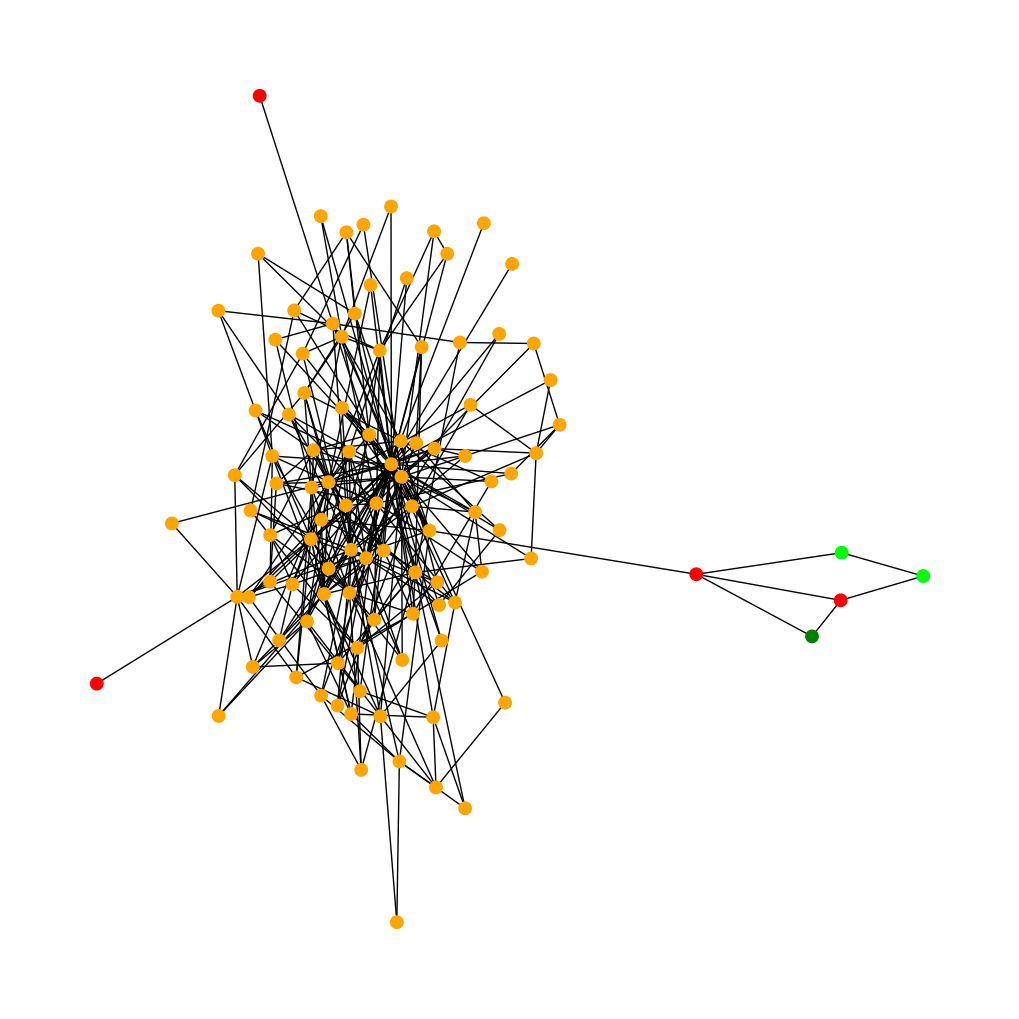

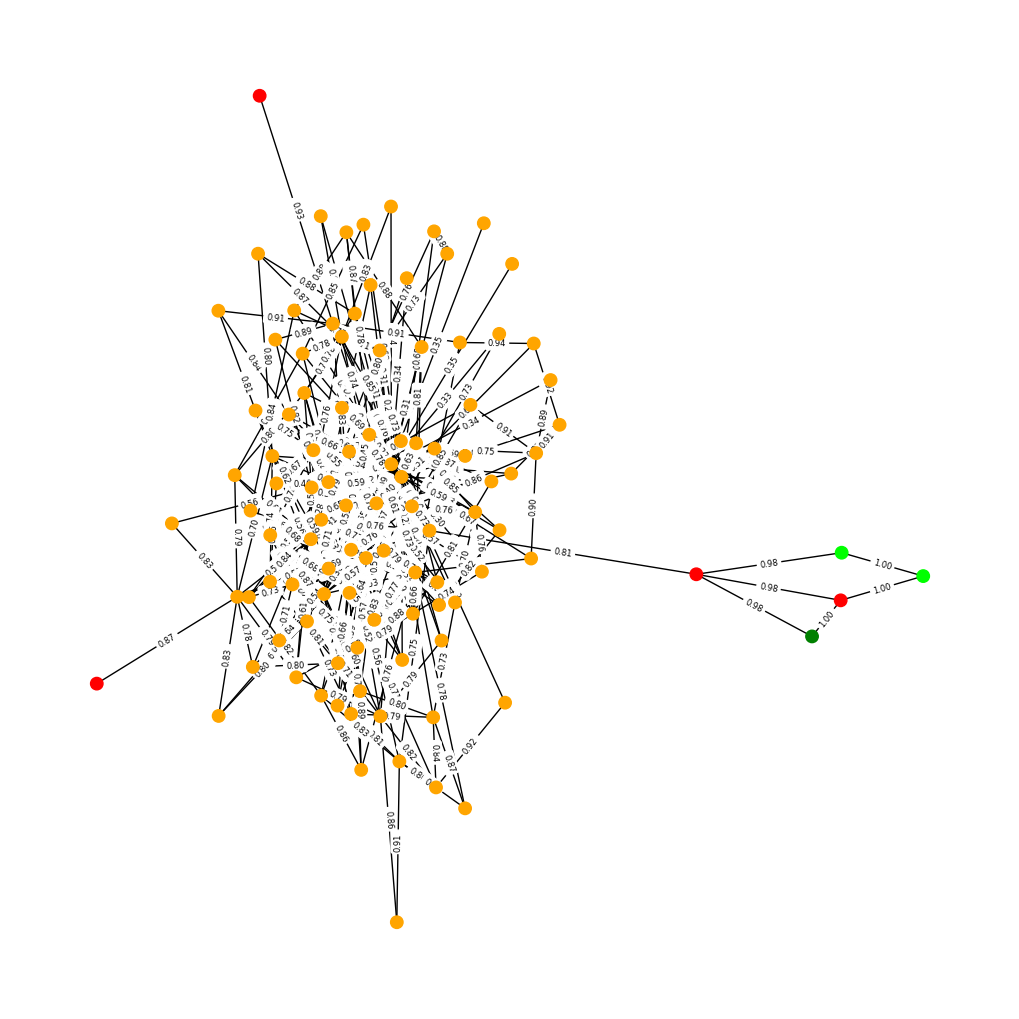

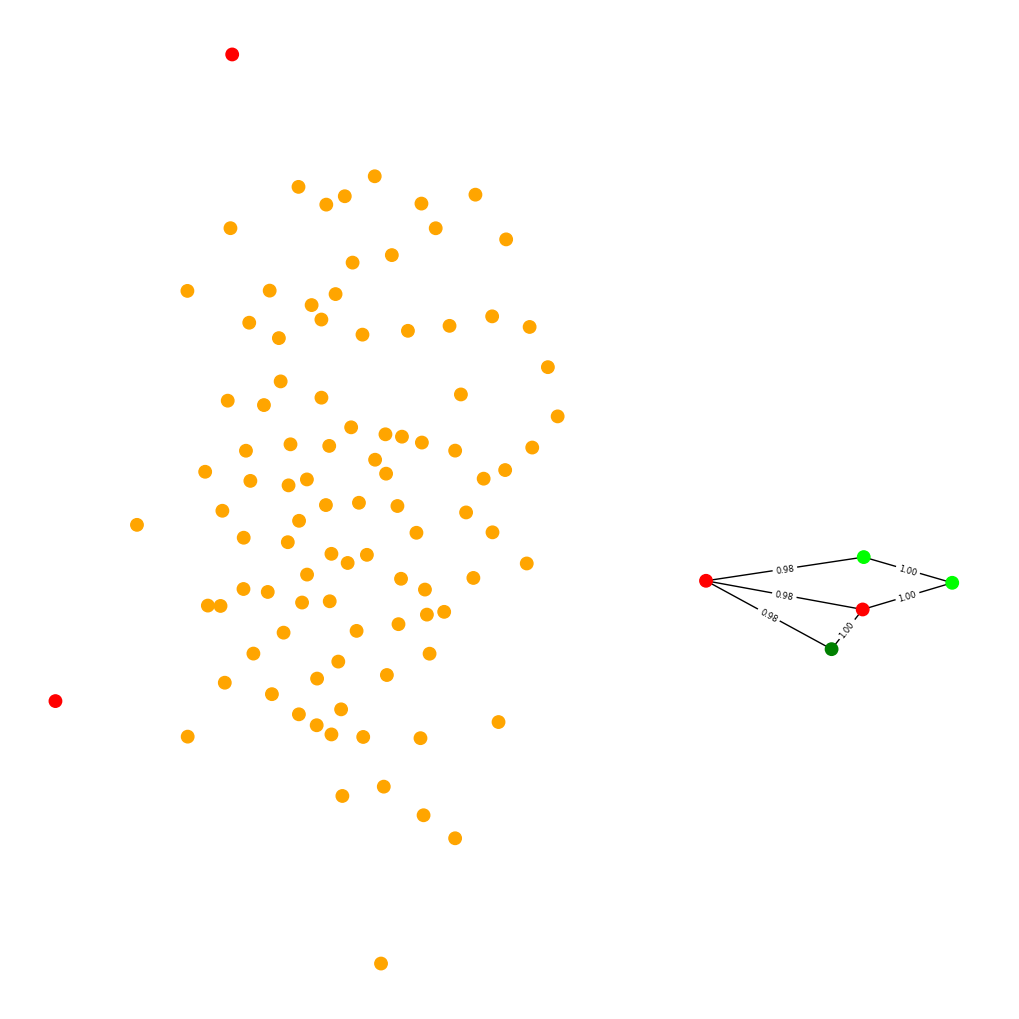

In [24]:
k = 6

mlp.eval()
downstreamTask.eval()

#AUCNode = [i for i in range(511,871,6)]
#AUCNode = [i for i in range(a[0].item(),a[len(a)-1]+1,6)]

#print(data.edge_index)

print(evaluation.evaluateNodeExplainerAUC(mlp, downstreamTask, data, data.edge_index, currentAUC, data.gt, k=k))

subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=currentAUC, num_hops=3, edge_index=data.edge_index, relabel_nodes=True)

indexNodeToPred = (subset == currentAUC).nonzero().item()

G_hop = Data(x=data.x[subset], edge_index=edge_index_hop, y=data.y[subset])

pos = utils.plotGraphAll(G_hop)




w_ij = mlp.forward(downstreamTask, data.x[subset], edge_index_hop, indexNodeToPred)

# Min-Max Normalization. This works pretty well
weights_min = w_ij.min()
weights_max = w_ij.max()
weights_norm = (w_ij - weights_min) / (weights_max - weights_min)

#print(torch.unique(w_ij))
edge_ij = mlp.sampleGraph(w_ij, temperature)

## REMOVE IF SIGMOID WANTED
edge_ij = weights_norm


GraphSampled = Data(x=G_hop.x, edge_index=G_hop.edge_index, y=G_hop.y, edge_attr=edge_ij.detach())

pos = utils.plotGraphAll(GraphSampled, pos, edge_weights=True)


# Print topK edges
k = k * 2 if len(w_ij) >= k*2 else len(w_ij)
_, top_k_indices = torch.topk(edge_ij, k=k, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = G_hop.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

GtopK = Data(x=G_hop.x, edge_index=edge_index_masked, y=G_hop.y, edge_attr=weights_masked)

pos1 = utils.plotGraphAll(GtopK, pos=pos, color_map=None, edge_weights=True)